In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai import *

In [7]:
mnist_path = Path('~/.fastai/data/mnist').expanduser()

MNIST as a dataset to illustrate the concepts of weight decay and momentum with SGD

### Data

basic pytorch only

In [8]:
with gzip.open(mnist_path/'mnist.pkl.gz', 'rb') as f:
    (x_train,y_train), (x_valid, y_valid),(_,_) = pickle.load(f, encoding='latin-1')

In [9]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, [x_train, y_train, x_valid, y_valid])

In [10]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [11]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

### Models

regular logistic regression and a NN with one hidden layer

In [12]:
class MnistLog(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [13]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784,100)
        self.lin2 = nn.Linear(100,10)
        
    def forward(self, xb):
        return self.lin2(F.relu(self.lin1(xb)))

### Optimization

we define step and fit not in a general purpose way, just so that we can see how weight decay and momentum work

In [14]:
# lr=0.1
# momemtum=0.9
# wd = 0.1
loss_fn = F.cross_entropy

In [15]:
model = MnistLog()
# model = MnistNN()

In [16]:
def step(model,  momentum, lr=0.001, wd=0.01):
    with torch.no_grad():
        for p in model.parameters():
            if hasattr(p, 'last_step') is False: p.last_step=torch.zeros_like(p.grad)
            ## grad
            current_step = lr*p.grad
            ## weight decay
            current_step.add_(lr*wd, p)
            ## momentum
            current_step.add_(momentum, p.last_step)
            ## store and update
            p.sub_(current_step)
            p.last_step=current_step
    model.zero_grad()
    

In [19]:
def _get_valid_accuracy(model):
    return np.array([accuracy(model(xb),yb) for xb,yb in valid_dl]).mean()

def fit(momentum=0.9, reset_model=False):
    steps=0
    if reset_model: model = MnistNN()
    valid_accuracies=[]
    for xb,yb in train_dl:
        loss = loss_fn(model(xb), yb)
        loss.backward()
        step(model, momentum)

        with torch.no_grad():
            if steps%5==0:
                valid_acc = _get_valid_accuracy(model)
#                 print(valid_acc)
                valid_accuracies.append(valid_acc)
                if valid_acc>0.95:
                    return valid_accuracies
                    break
        steps += 1
    return valid_accuracies

In [20]:
valid_accs_3 = fit(momentum=0.5, reset_model=True)
valid_accs_2 = fit(momentum=0.0, reset_model=True)
valid_accs_1 = fit(momentum=0.9, reset_model=True)

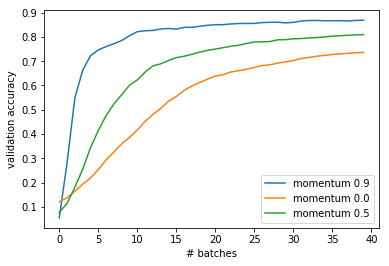

In [246]:
_, ax = plt.subplots()
ax.plot(valid_accs_1, label='momentum 0.9')
ax.plot(valid_accs_2, label='momentum 0.0')
ax.plot(valid_accs_3, label='momentum 0.5')
plt.xlabel('# batches')
plt.ylabel('validation accuracy')
ax.legend()

In [249]:
valid_accs_3

[0.07732882,
 0.11425159,
 0.18093152,
 0.25527468,
 0.34345144,
 0.41480893,
 0.4759156,
 0.5240844,
 0.56240046,
 0.6013137,
 0.62300956,
 0.6553543,
 0.68103105,
 0.6891919,
 0.703125,
 0.7148686,
 0.7205414,
 0.7288017,
 0.7374602,
 0.7446258,
 0.75009954,
 0.7557723,
 0.7617436,
 0.765824,
 0.77298963,
 0.77925956,
 0.7799562,
 0.781051,
 0.7883161,
 0.7888137,
 0.7923965,
 0.7932922,
 0.7960788,
 0.79757166,
 0.79986066,
 0.803543,
 0.80513537,
 0.8067277,
 0.8088177,
 0.8094148]

In [86]:
model.lin.bias

Parameter containing:
tensor([-0.0019,  0.0354, -0.0114,  0.0203, -0.0081,  0.0141, -0.0099, -0.0118,
        -0.0557, -0.0205], requires_grad=True)

In [87]:
bias = model.lin.bias
t = torch.randn_like(bias)

In [88]:
bias.add(t)

tensor([-0.4084,  0.0785, -0.4113,  0.4373,  0.5821,  0.1681, -1.3274,  0.6934,
         2.0852, -0.2062], grad_fn=<AddBackward0>)

In [91]:
bias.add(-0.1, t)

tensor([ 0.0388,  0.0311,  0.0286, -0.0214, -0.0671, -0.0013,  0.1218, -0.0823,
        -0.2698, -0.0020], grad_fn=<AddBackward0>)

In [210]:
bias.add(0,t)

tensor([-0.0021,  0.0372, -0.0134,  0.0186, -0.0065,  0.0162, -0.0114, -0.0127,
        -0.0573, -0.0178], grad_fn=<AddBackward0>)

In [211]:
bias

Parameter containing:
tensor([-0.0021,  0.0372, -0.0134,  0.0186, -0.0065,  0.0162, -0.0114, -0.0127,
        -0.0573, -0.0178], requires_grad=True)